# Construction d'un système de recommandation

Nous avons décidé d'orienter notre projet sur la recommendation de films.
En effet durant ce confinement, nous avons eu le temps de visionner beaucoup de films,
mais nous nous sommes rendus compte que nous passions quasiment autant de temps
à choisir le film qu'à le regarder. D'où la nécessité de créer un système de re-
commendations afin d'optimiser notre temps de visionnage.
Nous avons chercher une base de données assez exploitable afin de mener à bien
notre projet. Nous nous sommes basés sur la base de données de 'The Movies Dataset'.

[sommaire](#sommaire)

# Reste à faire

- [x] approche linéaire 
- [x] class hybride
- [x] CV grid search pour model-based hyperparamètres
- [ ] comparer score pour les prédicteurs
- [ ] comparer score pour les predicteurs hybride (devrait être moindre)
- [ ] documentation docstring
- [ ] documentation markdown

# À dire dans rapport pdf

- utilisation des magic command timeit, lprun pour optimiser le code, trop lent au début, on a réussi à accélérer tout ça en utilisant des numpy array quand c'était possible et en indexant ratings avec userId et movieId pour des accès plus direct (note d'Anita : est ce qu'on a bien fait ça tout le temps ? moi oui mais j'ai pas regardé pour vos fonctions)
- présentation succinte des différentes méthodes implémentée
- que la plupart du temps, on donne les hyperparametres en arguments mais qu'on leur donne nos valeurs pref apr défaut. Comme ça, ça peut tourner avec nos choix d'hyperparam, mais que l'utilisateur peut quand même avoir la main dessus
- sources de nos inspi
- pourquoi pas de k-mean ?

**Importation des packages**

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re

from ast import literal_eval
from itertools import product
from time import time

In [2]:
# %load_ext line_profiler

# Chargement et nettoyage des données

<span style="color:blue"> description des différentes tables </span>

In [3]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
link = pd.read_csv("links_small.csv")

/Users/anita/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [7]:
def filter_correct_id(word):
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

In [8]:
def simplify_genre(l):
    if len(l) <= 0 :
        return []
    if isinstance(l[0], dict):
        return [d['name'] for d in l]
    return l

<span style="color:blue"> explication du nettoyage effectué </span>

In [9]:
# do not re-run !

movies = movies.drop_duplicates('id')
keywords = keywords.drop_duplicates('id')
credits = credits.drop_duplicates('movie_id')

movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')
movies[movies['vote_count'].notnull()]['vote_count'].astype('int64', copy=False)
movies[movies['vote_average'].notnull()]['vote_average'].astype('int64', copy=False)

ratings = ratings.drop(columns=['timestamp'])

movies = movies.rename(columns={'id' : 'tmdbId'})
keywords = keywords.rename(columns={'id' : 'tmdbId'})
credits = credits.rename(columns={'movie_id' : 'tmdbId'})

# Sommaire <a id='sommaire'></a>

Nous avons différenciés deux types de systèmes de recommendations. 

- Les **Recommender** recommendent à un utilisateur des films qu'il sera susceptible d'aimer, sans explicitement prédire la note que l'utilisateur donnera à ses films. Nous en avons implémenté deux types:

    1. un système utilisant la popularité des films dans une catégorie donnée [popularity-based](#popularity)
    2. un système utilisant les méta-informations des films [clustering](#clustering)


- Les **Predictor** prédisent les notes que des utilisateurs donneront à des films. Nous en avons implémenté deux types :
    3. un système basé sur les données connues (user- et item-based présenté en cours) [memory-based](#memory)
    4. un système basé sur un modèle [model-based](#model)


- Les systèmes **Hybride** font le mélange des deux. Ils recommendent à un utilisateur des films qu'il sera susceptible d'aimer en utilisant des prédictions de notes. Nous avons implémenté une classe qui prend en argument un Recommender et un Predictor:
    5. [hybride](#hybride)
    

- Compaison critique des différentes méthodes : [score](#score)



# Films les plus populaires par genre <a id='popularity'></a>

[retour au sommaire](#sommaire)

Une méthode simple pour recommander des films à un utilisateur, est de lui présenter la liste des films les plus populaires appartenant à ses genres préférées. Ainsi il faudra dans un premier temps identifier ses genres préférés, puis établir la liste des films les plus populaires qui figurent parmi ces genres.

Pour cette méthode, nous allons utiliser les données contenues dans les colonnes `vote_average` et `vote_count`. En effet, il y a plus de votes récoltés dans cette table quand dans `ratings`. Les utilisateurs ont utilisé une notation allant de 0 à 10.

L'initialisation d'un objet de `PopularityRecommender` traite les données entrée pour rendre la recommendation plus efficace. La dataframe `dfm` de schéma *dfm(movieId, title, vote_average, vote_count)* contient la liste des films identifiés par leur `movieId`. Pour pouvoir sélectionner les films par genre, et parce qu'un film peut appartenir à plusieurs genres, nous utlisons une table `sgr` dans laquelle chaque ligne n'indique qu'un seul genre du film. Indexer ces deux tables par l'attribut `movieId` nous permet d'accélerer la sélection des lignes puisqu'elle ne se fait presque que par `movieId`. Enfin, la table `dfm` contient les notes des utilisateurs et des films. Elle est utilisée pour déterminer les genres préféres d'un user donné : la méthode `pref_genres` selectionne les genres des 3 films préférés de l'utilisateurs. 


<span style="color:blue"> selection des genres peut être à faire de manière plus accurate ? genre donner plus d'importance à un certain genre ? </span>

<span style="color:blue"> utilisation d'une fonction extérieure à la classe : même problème avec memory et les fct de corrélations </span>


Pour évaluer la popularitée d'un film au sein d'un catégorie de films, nous utilisons la formule de *weighted rating* utilisée par le site TMDB : 
$$
WR = \frac{v}{v + m} R + \frac{m}{v +m} C
$$

où 
- $R$ est la note moyenne du film (vote_average) ;

- $v$ est le nombre de notes que le film a reçu (vote_count) ; 

- $m$ est le nombre minimum de votes qu'un film doit recevoir pour pouvoir figurer sur la liste ;

- $C$ est la note moyenne donnée dans toute l'étude.


Si $R$, $v$ et $C$ se calculent à partir des données, il nous faut choisir le seuil $m$. Nous allons considérer qu'un film doit avoir eu plus de votes qu'au moins 80% des films pour pouvoir aparaître dans le top du genre. Ce paramètre permet de ne considérer que des films qui ont été vu par une majorité de personnes et qui peuvent être donc considérés comme populaire. 

In [10]:
class PopularityRecommender:
    def __init__(self):
        self.dfr = None
        self.dfm = None
        self.sgr = None
    
    def fit(self, movies, ratings, link) :
        self.dfr = ratings[['userId', 'movieId', 'rating']].set_index(['userId', 'movieId'])
        
        # construction de la table des films identifiés par leur movieId
        self.dfm = movies[['tmdbId', 'title', 'genres', 'vote_average', 'vote_count']]
        self.dfm = link.merge(self.dfm, left_on='tmdbId', right_on='tmdbId').drop(columns=['tmdbId', 'imdbId'])
        self.dfm.set_index('movieId', inplace=True)
        
        # transformer la description JSON de genres en liste de string plus simple à manipuler
        self.dfm['genres'] = self.dfm['genres']\
                    .apply(lambda x: literal_eval(x) if isinstance(x, str) else x)\
                    .apply(simplify_genre)

        # construction d'une série dans laquelle les lignes ne contiennent qu'un seul genre
        self.sgr = self.dfm.apply(lambda x: pd.Series(x['genres'], dtype='str'),axis=1).stack().reset_index(level=1, drop=True)
        self.sgr.name = 'genre'
    
    def recommend(self, uid, dfr, n=20):
        '''
        :param: uid l'identifiant de l'utilisateur
                n le nombre de films à recommender
        :return: une dataframe contenant les n films les plus populaires appartenant aux genres préférés de l'user uid
        '''
        assert self.dfr is not None, "This PopularityRecommender instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        
        # récupérer les films les plus populaires des genres préférés de uid
        chart = self._best_(self.pref_genres(uid), n*10)
        
        # ne retenir que les films non encore visionnés
        watched_movies = self.dfr.loc[uid, :].index.unique()
        watched_movies = chart.index.isin(watched_movies)
        chart = chart.loc[~watched_movies]


        return chart.head(n).index if len(chart) > n else chart.index
    

    def pref_genres(self, uid):
        '''
        :param: uid l'identifiant de l'utilisateur
        :return: une liste des genres des 3 films préférés de l'user uid
        '''
        rats = self.dfr.loc[uid, :].sort_values(by='rating', ascending=False)
        pref = rats.head(3).index if rats.shape[0] > 5 else rats.index
        genres = []
        for g in self.dfm.loc[pref].genres :
            genres = list(set(genres) | set(g))
        return genres

    def _best_(self, genres, k=200):
        '''
        :param: genres une liste de genres sous forme de str
                k le nombre de films à retenir
        :return: les k films les plus populaires appartenant à au moins un genre dans la liste genres
        '''
        # select movies that are in genres
        dfg = self.sgr[self.sgr.isin(genres)]
        dfg = self.dfm.loc[dfg.index.drop_duplicates()] 
        # need to drop duplicates : a movie can be selected because 2 or more of its genres are ok

        m = dfg.vote_count.quantile(0.8)
        
        # sort movies by decresing weighted rating
        top = dfg[(dfg['vote_count'] >= m)]
        top['wr'] = self.weighted_rating(top[['vote_count', 'vote_average']].to_numpy(), m)
        top.sort_values('wr', ascending=False, inplace=True)

        # drop unnecessary columns
        top.drop(columns=['vote_count', 'vote_average'], inplace=True)

        return top.head(k) if len(top) > k else top
    
    def weighted_rating(self, x, m):
        '''
        :param: x une matrice numpy de format suivant
                    chaque ligne correspond à un films
                    la première colonne x[: 0] contient le nombre de votes reçus par le films
                    la deuxième colonne x[: 1] content la note moyenne de chaque film
                m le nombre minimum de votes qu'un film doit recevoir pour pouvoir figurer sur la liste
        :return: un numpy array contenant la note pondérée que chaque film
        '''
        v = x[:, 0] # liste du nombre de vote
        R = x[:, 1] # liste des notes moyennes
        C = sum(np.multiply(v, R)) / sum(v) # note moyenne attribuée
        return np.multiply(v/(v+m), R) + np.multiply(m/(m+v), C)

# Clustering des films<a id='clustering'></a>

[retour au sommaire](#sommaire)

### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier.

Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films.

In [11]:
dfm_cluster = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')

In [12]:
dfm_cluster = dfm_cluster.merge(ratings.drop_duplicates('movieId'), how='inner')

In [13]:
dfm_cluster = dfm_cluster.join(keywords.set_index('tmdbId'), on='tmdbId', how='inner')

In [14]:
title_id = dfm_cluster[['tmdbId','movieId','title']]
cluster_features = dfm_cluster[['title', 'genres', 'keywords', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features.index = dfm_cluster.movieId.apply(lambda x: str(x))
cluster_features.head()

,title,genres,keywords,release_date,production_countries,original_language,runtime
movieId,,,,,,,
1,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,81.0
2,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",1995-12-15,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,104.0
3,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,101.0
4,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,127.0
5,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",1995-02-10,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,106.0


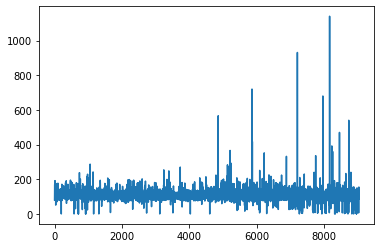

In [15]:
plt.plot(cluster_features.runtime.values)

On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

In [16]:
def clean_runtime(dfm, inf=40, sup=240):
    dfm = dfm[dfm.runtime >= inf]
    dfm = dfm[dfm.runtime <= sup]
    return dfm

In [17]:
cluster_features = clean_runtime(cluster_features)

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [18]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")

Nombre de films retenus dans cluster_features :  8897
Parmi ces films :
30 n'ont pas de genres
718 n'ont pas de keywords
270 n'ont pas de production_countries


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [19]:
def drop_missing_values(dfm):
    
    '''This function takes a movie DataFrame with genres, keywords and production_countries
    attributes, and it removes the rows for which there is no information on these features,
    i.e. when one or more attributes of the movie Series equals the string of an empty list.'''
    
    dfm = dfm[dfm.genres != "[]"]
    dfm = dfm[dfm.keywords != "[]"]
    dfm = dfm[dfm.production_countries != "[]"]
    return dfm

In [20]:
cluster_features = drop_missing_values(cluster_features)

In [21]:
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  8037


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [22]:
def vectorize_genres(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'genres'.
    It turns the column genres from a string that contains a dictionnary into an int list of genres id.'''
    
    def genres_to_id(gen):
        if isinstance(gen, str):
            pattern = re.compile(r"'id': [0-9]*")
            return np.array([int(w[6:]) for w in pattern.findall(gen)])
        return gen
    
    dfm.genres = dfm.genres.apply(genres_to_id)

In [23]:
vectorize_genres(cluster_features)

In [24]:
def vectorize_keywords(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'keywords'.
    It turns the column keywords from a string that contains a dictionnary into an int list of keywords id.'''
    
    def keywords_to_id(kw):
        if isinstance(kw, str):
            pattern = re.compile(r"'id': [0-9]*")
            return np.array([int(w[6:]) for w in pattern.findall(kw)])
        return kw
    
    dfm.keywords = dfm.keywords.apply(keywords_to_id)

In [25]:
vectorize_keywords(cluster_features)

In [26]:
def simplify_date(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'release_date'.
    It turns the column release_date from a string date into an int being the year the film was released.'''
    
    def date_to_int(date):
        if isinstance(date, str):
            return int(date[:4])
        return date
    
    dfm.release_date = dfm.release_date.apply(date_to_int)

In [27]:
simplify_date(cluster_features)

In [28]:
def simplify_countries(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'production_countries'.
    It turns the column production_countries from a string that contains a dictionnary into an int list of keywords id.'''
    
    def simplify(country):
        if isinstance(country, str):
            pattern = re.compile(r"'iso_3166_1': ...")
            return [w[15:] for w in pattern.findall(country)]
        return country
    
    dfm.production_countries = dfm.production_countries.apply(simplify)

In [29]:
simplify_countries(cluster_features)

In [30]:
cluster_features.head()

,title,genres,keywords,release_date,production_countries,original_language,runtime
movieId,,,,,,,
1,Toy Story,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",1995,[US],en,81.0
2,Jumanji,"[12, 14, 10751]","[10090, 10941, 15101, 33467, 158086, 158091]",1995,[US],en,104.0
3,Grumpier Old Men,"[10749, 35]","[1495, 12392, 179431, 208510]",1995,[US],en,101.0
4,Waiting to Exhale,"[35, 18, 10749]","[818, 10131, 14768, 15160, 33455]",1995,[US],en,127.0
5,Father of the Bride Part II,[35],"[1009, 1599, 2246, 4995, 5600, 10707, 13149, 3...",1995,[US],en,106.0


### Définition d'une distance sur les films

On va réaliser plus bas un hierarchical agglomerative clustering. Le principe est simple : on commence avec n clusters de 1 film, puis on fusionne à chaque itération les 2 clusters les plus proches, jusqu'à n'avoir plus d'un seul cluster contenant tous les films. Cela requiert une distance sur les films. C'est ce qu'on va construire ici. La tâche n'est pas simple : chaque film a été réduit à 6 attributs, et il faut aggréger ces 6 attributs pour déterminer à quel point 2 films sont similaires. On peut choisir d'accorder un poids différent à chacun des critères en fonction de leur importance.

In [31]:
# On définit ici des variables globales qui seront utilisées plus loin dans la fonction movie_distance
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

La fonction movie_distance calcule une distance entre 2 films. Plus cette valeur est proches de 0 et plus les films sont similaires. Plus la valeur est grande et plus ils sont différents. IMPORTANT : la built-in magic command %lprun nous a permis d'analyser la répartition du temps d'exécution lors du clustering sur les données. 99% du temps de calcul réside dans cette fonction de distance. Ce qui est le plus coûteux en temps est l'accès aux attributs des films. On les a donc réduit au strict minimum. De plus, on ne créé pas de vecteur à 6 coefficients qui stockerait la similitude entre les 2 films pour chaque critère. A la place, on additionne directement le carré de ces valeurs dans une variable de somme, puis on renvoit la racine carrée de cette variable. On utilise la norme 2 en la calculant à la main pour accélérer les calculs.

In [32]:
def movie_distance(movie1, movie2, w_gen=4, w_key=2, w_rel=2, w_pro=3, w_ori=2, w_run=1):
    
    '''This function computes the distance between 2 movies m1 and m2 given some weight parameters.
    It can be called either with 2 lists of attributes or with 2 movie Series, but the 2 parameters
    must have the same type.'''
    
    assert type(movie1) is type(movie2)
    sum_vect = 0 # avoiding to store a vector just to compute his norm afterwards
    
    if isinstance(movie1, pd.Series):
        g1, g2 = movie1.genres, movie2.genres
        kw1, kw2 = movie1.keywords, movie2.keywords
        r1, r2 = movie1.release_date, movie2.release_date
        pc1, pc2 = movie1.production_countries, movie2.production_countries
        lang1, lang2 = movie1.original_language, movie2.original_language
        run1, run2 = movie1.runtime, movie2.runtime
    else:
        # Access to both movie's attributes stored in the lists movie1 and movie2
        g1, g2 = movie1[0], movie2[0]
        kw1, kw2 = movie1[1], movie2[1]
        r1, r2 = movie1[2], movie2[2]
        pc1, pc2 = movie1[3], movie2[3]
        lang1, lang2 = movie1[4], movie2[4]
        run1, run2 = movie1[5], movie2[5]
    
    # SIMILARITIES IN GENRES
    gen = np.append(g1, g2)
    sum_vect += w_gen * (1 - (len(gen) - len(np.unique(gen))) / min(len(g1), len(g2))) ** 2
    
    # SIMILARITIES IN KEYWORDS
    kw = np.append(kw1, kw2)
    # Having one keyword in common is sufficient to make 2 films similar for this criterion
    # This choice was made because most films have many keywords
    if len(kw) == len(np.unique(kw)):
        sum_vect += w_key * 1 # ** 2
    
    # SIMILARITIES FOR THE RELEASE DATE
    # the normalized difference between the 2 releade dates
    sum_vect += w_rel * (abs(r1 - r2) / MAX_YEAR_DIFFERENCE) ** 2
    
    # SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc.extend(pc1)
    pc.extend(pc2)
    pc_dist = 1 - (len(pc) - len(np.unique(pc))) / min(len(pc1), len(pc2))
    # As it is rare, we set that 2 films which are not from the US have something in common
    if 'US' not in pc1 and 'US' not in pc2 and pc_dist > 0.5:
        sum_vect += w_pro * 0.5 ** 2
    else:
        sum_vect += w_pro * pc_dist ** 2
    
    # SIMILARITIES FOR THE LANGUAGE
    if lang1 != lang2 :
        # As well, 2 films whose original language is not english have something in common
        if lang1 != 'en' and lang2 != 'en':
            sum_vect += w_ori * 0.5 ** 2
        else:
            sum_vect += w_ori * 1 ** 2
    
    # SIMILARITIES FOR THE RUNTIME
    # the normalized difference between the 2 runtimes
    sum_vect += w_run * (abs(run1 - run2) / MAX_RUNTIME_DIFFERENCE) ** 2
    
    return np.sqrt(sum_vect)

Maintenant qu'on dispose d'une distance entre les films, on doit calculer la matrice de distance entre les films. Pour cela, on va utiliser un DataFrame avec en index et columns les id des movies (en string pour éviter toute confusion avec loc et iloc). On initilise un DataFrame vide avec les bonnes dimensions et les bons index / columns. On le remplit ensuite en faisant appel à la fonction movie_distance pour chaque paire de films. Comme par la suite on veut chercher le coefficient minimum de cette matrice, on met la distance d'un film à lui même à 1000 - un nombre suffisemment grand pour qu'aucune autre valeur de distance ne l'approche avec les choix de poids qu'on a fait.

In [33]:
def compute_dist_matrix(clu_fea):
    
    '''This function computes the distance matrix between all the movies contained in clu_fea.
    The clu_fea DataFrame must have been cleaned before. Returns the distance matrix.'''
    
    movies_id = clu_fea.index
    dist_mat = pd.DataFrame(np.nan * len(clu_fea), index=movies_id, columns=movies_id)
    
    # Faire des .loc / .iloc sur un DataFrame prend enormement de temps. Pour eviter cela,
    # on le fait pour chaque attribut de chaque film une bonne fois pour toutes, et on stocke
    # cela dans une matrice. On est forcé d'utiliser une double liste python car chaque element
    # de la matrice peut etre de type int, float, str ou encore list. C'est envrion 4 fois plus
    # rapide que de rester avec un DataFrame en accédant aux attributs des films !
    
    mat_mem = []
    for i in range(len(clu_fea)):
        mov_i = clu_fea.iloc[i]
        mat_mem.append([mov_i.genres, mov_i.keywords, mov_i.release_date,
                     mov_i.production_countries, mov_i.original_language, mov_i.runtime])
    
    # On peut maintenant calculer la distance entre chaque paire de films
    # La distance d'un film avec lui meme est fixee a 1000 par defaut
    # pour eviter de fusionner un cluster avec lui meme
    
    for i in range(len(clu_fea)):
        for j in range(i, len(clu_fea)):
            if i == j:
                dist_mat.iat[i, j] = 1000
            else:
                dist_mat.iat[i, j] = dist_mat.iat[j, i] = movie_distance(mat_mem[i], mat_mem[j])
    
    return dist_mat

<b>HIERARCHICAL AGGLOMERATIVE CLUSTERING </b> <br>
Dans ce type de méthode de clustering, on n'a pas besoin de préciser le nombre de clusters attendus. L'algorithme permet de construire un dendrogramme, et on obtient nos clusters en coupant le dendrogramme à une certaine hauteur. On va commencer par écrire une classe Dendrogram. Un objet de cette classe contient plusieurs attributs :
<li>Un champ leaf - valant None pour les noeuds dans l'arbre et contenant l'id d'un film (int) pour les feuilles </li>
<li>Un champ leaf_nb - un int indiquant pour chaque noeud le nombre de feuilles (et donc de films) de l'abre issu de ce noeud </li>
<li>Un champ father - une référence vers le père du noeud </li>
<li>Un champ left et un champ right - une référence vers le fils gauche (resp. fils droit) du noeud </li>
<li>Un champ height - un float indiquant la hauteur du noeud. Attention ! Il ne s'agit pas de la notion classique de hauteur d'un noeud dans un arbre binaire. <br>Il s'agit ici de la hauteur de fusion entre les 2 groupes de films (fils gauche et fils droit). Plus elle est élevée et plus ces 2 groupes de films sont différents </li>
<li>Un champ distance_to_father - un float indiquant la longueur de l'arête reliant le noeud à son père </li>

In [34]:
class Dendrogram:
    
    def __init__(self, leaf=None):
        
        '''This is the Dendrogram class constructor. It takes only one optional argument, which is leaf if the user
        wants to build a leaf containing a movie id. Otherwise it is a node and the leaf attribute is set to None.
        The other attributes are set to 0 or None for now, and should be modified by setters later on.'''
        
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
        self.height = 0
        self.distance_to_father = 0
    
    def set_leaf_nb(self):
        
        '''This method is a setter for the leaf_nb attribute. It requires the left and right sons, as the total number
        of leaves of the node is the sum of its left and right leaf_nb attributes. If called on a leaf, leaf_nb should
        equal 1 due to the constructor, and set_leaf_nb set leaf_nb to 1 as well. This methode should always be called
        after creating a node that is not a leaf.'''
        
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def set_height(self, height):
        
        '''This method is a setter for the height attribute. The height is given as a parameter. This method also sets
        the distance_to_father attribute of the node's left and right sons. If called on a leaf, this method does nothing.
        This methode should always be called after creating a node that is not a leaf.'''
        
        if self.left is None or self.right is None:
            return
        self.height = height
        self.left.distance_to_father = height - self.left.height
        self.right.distance_to_father = height - self.right.height
    
    def get_id_list(self):
        
        '''This method returns a list of all the id contained in the leafs of the node.It uses a prefix run.'''
        
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        
        '''This method returns the root of the tree to which the node belongs. The main goal of this method is
        to start from a leaf and find the root of the dendrogram, which is the leaf's cluster at a step k.'''
        
        tmp = self
        while tmp.father is not None: tmp = tmp.father
        return tmp
    
    def cut_at_threshold(self, threshold):
        
        '''This method provides a cut of the dendrogram at a height given by parameter threshold. It returns a list
        of Dendrogram objects. Each element of the list can be seen as the root of a dendrogram, i.e. a cluster.'''
        
        assert threshold >= 0
        assert threshold <= self.height
        node_list = []
        def step(node, t):
            if node.height == 0:
                node_list.append([node])
            else:
                if node.left.height <= t:
                    node_list.append(node.left)
                else:
                    step(node.left, t)
                if node.right.height <= t:
                    node_list.append(node.right)
                else:
                    step(node.right, t)
        step(self, threshold)
        
        return node_list
    
    def clusters_threshold_cut(self, threshold):
        
        '''This method uses cut_at_threshold in order to return a list of movies id list. Each element
        of the list is a cluster that directly contains the id of all movies that belong to the cluster.'''
        
        cluster_list = self.cut_at_threshold(threshold)
        return [node.get_id_list() for node in cluster_list]
    
    def find_best_cut(self):
        
        '''This method does dendrogram cuts at 200 different threshold and keeps the best cut. It returns a list of
        movies id list, i.e. the different clusters. Some changes had to be made to avoid getting too many clusters.
        This is due to the distance choice between movies. Some attributes such as director or keywords are almost
        all different for 2 movies, resulting in a high distance between most movies, even between 2 movies that are
        very similar regarding genres, language, release date, production countries and runtime. That is why the method
        imposes a maximum number of clusters, which depends on the size of the input. The upper bound is quite high so
        that it enables many clusters, and it avoids to have some situations with e.g. 100 movies and 43 clusters.'''
        
        max_clu_nb = self.leaf_nb / np.sqrt(self.leaf_nb)
        threshold_list = np.linspace(0.01, self.height, 200)
        def step(t):
            nodes = self.cut_at_threshold(t)
            if len(nodes) > max_clu_nb:
                return 0
            return sum([n.distance_to_father for n in nodes]) / len(nodes)
        score = [step(t) for t in threshold_list]
        best_threshold_index = np.argmax(score)
        best_threshold = threshold_list[best_threshold_index]
        
        return self.clusters_threshold_cut(best_threshold)
    
    def get_n_clusters(self, n):
        
        '''This method provides a cut on the dendrogram that gives a number n of clusters, chosen in parameter.
        The different clusters are obtained by cutting at a threshold that leads to n clusters.
        It uses dichotomy in order to be efficient. It tries a cut at mid-height, check the number of
        clusters obtained and then decides to stop, cut at a higher height or cut at a lower height.'''
        
        assert n >= 1
        assert n <= self.leaf_nb
        # dichotomy
        xmin, xmax, xmid = 0, self.height, self.height / 2
        nodes = self.cut_at_threshold(xmid)
        while len(nodes) != n:
            if len(nodes) < n: 
                xmax, xmid = xmid, (xmid + xmin) / 2
            else:
                xmin, xmid = xmid, (xmid + xmax) / 2
            nodes = self.cut_at_threshold(xmid)
            # if the loop does not end - extremely unlickely but not impossible if 2 nodes
            # have the same height - it calls another cut function that returns n clusters
            if xmax - xmin < 1e-5:
                return self.get_n_clusters_perso(n)[0]
        
        return [n.get_id_list() for n in nodes]
        
    def get_n_clusters_perso(self, n):
        
        '''This method provides a cut on the dendrogram that gives a number n of clusters, chosen in parameter.
        It is called get_n_clusters_perso because I imaginated it alone and I don't think it exists elsewhere.
        The goal of this method is to solve the following problem : most of the time, cutting a dendrogram at
        a given height leads to a certain number of clusters. Among these clusters, some can be very small, there
        are even clusters with one element. So, instead of cutting at a threshold, the idea of this method is the
        following : it starts at the root and must provide n clusters, e.g. let's take n=10. If the left son's leaf
        number is greater than the right son's one, then the left son must provide let's say n=7 clusters, while the
        right son must provide n=3 clusters. Finally if the right son's have a very small number of leaves compared
        to the left son's one, then the left son must provide n=10 clusters and the leaves of the right son are added
        to a list of outliers. At the end of the process, there will be 10 clusters quite well balanced and one list
        of outliers, which can form a special cluster of, let's say, unclassifiable movies.'''
        
        if n <= 0 or n > self.leaf_nb:
            print("Bad choice for n : too big or <= 0")
            return
        cluster_list = []
        outliers = []
        error = []
        def step(node, n):
            if n == 1:
                cluster_list.append(node.get_id_list())
            elif node.left is None or node.right is None:
                error.append(True)
            else:
                prop_left = node.left.leaf_nb / node.leaf_nb
                prop_right = node.right.leaf_nb / node.leaf_nb
                # a node is considered an outlier if his leaf number
                # is less than 15% of his father's leaf number
                if prop_left < 0.15:
                    outliers.extend(node.left.get_id_list())
                    step(node.right, n)
                elif prop_right < 0.15:
                    outliers.extend(node.right.get_id_list())
                    step(node.left, n)
                else:
                    n_left = max(1, round(n * prop_left))
                    if n_left == n:
                        n_left -= 1
                    n_right = n - n_left
                    step(node.left, n_left)
                    step(node.right, n_right)
        step(self, n)
        if error:
            print("n too big")
        else:
            return cluster_list, outliers

On peut désormais écrire une classe pour implémenter le Hierarchical Agglomerative Clustering. Un objet de cette classe contiendra les attributs suivants :<br>
<li>Un champ dendrogram_root - une référence vers la racine du dendrogramme</li>
<li>Un champ cluster_id_list - une liste de listes de movies id, i.e. la liste des clusters</li>
<li>Un champ outliers - une liste de movies id, existant uniquement si on choisi la méthode perso</li>
<li>Un champ cluster_features - le DataFrame des films nettoyé sur lequel on apprend </li>

In [35]:
class HierarchicalClusterRecommender:
    
    def __init__(self):
        
        '''This is the HierarchicalCluster class constructor. It takes no arguments, all it does is to
        build an object. The 4 attributes will be initialized later on, when fiting the model.'''
        
        self.dendrogram_root = None
        self.cluster_id_list = None
        self.outliers = None
        self.cluster_features = None
    
    def set_cluster_features(self, dfm):
        
        '''This method is a setter for the attribute cluster_features. It takes one parameter, dfm, which is
        a DataFrame that contains all the information about movies. The method cleans the DataFrame and keeps
        only the attributes that are relevant for the movie clustering.'''
        
        # selection des attributs qui nous interessent pour le clustering
        clu_fea = dfm[['genres','keywords','release_date','production_countries','original_language','runtime']]
        # on met en index les id des movies
        clu_fea.index = dfm.movieId.apply(lambda x: str(x))
        # nettoyage du dataframe
        clu_fea = clean_runtime(clu_fea)
        clu_fea = drop_missing_values(clu_fea)
        vectorize_keywords(clu_fea)
        vectorize_genres(clu_fea)
        simplify_date(clu_fea)
        simplify_countries(clu_fea)
        self.cluster_features = clu_fea
    
    def agglomerative_cluster(self, dist_mat):
        
        '''This method builds a dendrogram based on the distance matrix given in parameters. It returns
        its root. Important things to know about this function : 1) In order to avoid redundancy and to make
        the computations faster, it reduces the matrix size at each step by dropping a row and a colums.
        At the end, the matrix has 1x1 shape, so if one wants to store the matrix and keep it unchanged,
        he must call this method with a copy. 2) A choice which has a huge impact on the dendrogram was made
        here. In the algorithm, the 2 closest clusters are merged into a bigger one at each step. But there are
        several ways to measure the distance between clusters. It can be the distance between the centroids, the
        average distance, the minimal or maximal distance bewteen 2 points from different clusters. We chose this
        last option. It avoids to have many unbalanced branches, especially at levels close to the root.'''
        
        assert self.cluster_features is not None
        clu_fea = self.cluster_features
        clu_fea["dendrogram"] = clu_fea.index
        clu_fea.dendrogram = clu_fea.dendrogram.apply(lambda x: Dendrogram(leaf=int(x)))
        size_mat = len(clu_fea)
        for _ in range(1, size_mat):
            # localisation de la plus petite distance dans la matrice
            index_str1, index_str2 = dist_mat.stack().idxmin()
            height = dist_mat.loc[index_str1, index_str2]
            mov1 = clu_fea.loc[index_str1]
            mov2 = clu_fea.loc[index_str2]
            tmp1 = mov1.dendrogram
            tmp2 = mov2.dendrogram
            # acces a la racine du cluster de mov1 et de celui de mov2
            while tmp1.father is not None: tmp1 = tmp1.father
            while tmp2.father is not None: tmp2 = tmp2.father
            # creation de la racine du nouvel arbre, fusion des 2 clusters
            tmp3 = Dendrogram()
            tmp3.left = tmp1
            tmp3.right = tmp2
            tmp1.father = tmp3
            tmp2.father = tmp3
            tmp3.set_leaf_nb()
            tmp3.set_height(height)
            # actualisation de la matrice de distance
            new_d = np.maximum(dist_mat.loc[index_str1, :], dist_mat.loc[index_str2, :])
            dist_mat.loc[index_str1, :] = dist_mat.loc[:, index_str1] = new_d
            # suppression d'une des 2 lignes et colonnes qui font maintenant doublons
            dist_mat = dist_mat.drop(index_str2, axis=0)
            dist_mat = dist_mat.drop(index_str2, axis=1)
        
        return clu_fea.iloc[0].dendrogram.get_root()

    
    def set_n_clusters(self, n):
        
        '''This method cuts the dendrogram at a height that forms n different clusters.'''
    
        assert self.dendrogram_root is not None, "Erreur, vous devez d'abord construire le dendrogram avec la methode fit."
        self.outliers = None
        self.cluster_id_list = self.dendrogram_root.get_n_clusters(n)
    
    def set_best_n_clusters(self):
        
        '''This method cuts the dendrogram at a height that maximizes the distance_to_father attributes
        of the cluster roots, on the condition that it doesn't create too many clusters.'''
        
        assert self.dendrogram_root is not None, "Erreur, vous devez d'abord construire le dendrogram avec la methode fit."
        self.outliers = None
        self.cluster_id_list = self.dendrogram_root.find_best_cut()
    
    def set_n_clusters_perso(self, n):
        
        '''This method cuts the dendrogram at different heights depending on the branch, so that if forms
        n clusters quite well balanced. It does not take the nodes height in consideration.'''
        
        assert self.dendrogram_root is not None, "Erreur, vous devez d'abord construire le dendrogram avec la methode fit."
        self.cluster_id_list, self.outliers = self.dendrogram_root.get_n_clusters_perso(n)
            
    def fit(self, dfm_cluster, method='set_best_n_clusters', n=None):
        
        '''This method coordinates the cluster construction. Firstly it cleans the DataFrame by calling the
        set_cluster_features method. Then it calls the function that computes the distance matrix. Finally
        it calls the agglomerative_cluster method in order to build the dendrogram. If fit is called twice
        or more times, for example in order to change the cut method or parameters, the dendrogram remains
        unchanged to avoid doing all computations again and for nothing. If one wants to change the dataset,
        the attribute dendrogram root has to be set to None.'''
        
        assert (method == 'set_best_n_clusters' and n is None) or (method != 'set_best_n_clusters' and n is not None)
        
        if self.dendrogram_root is None:
            self.set_cluster_features(dfm_cluster)
            dist_mat = compute_dist_matrix(self.cluster_features)
            self.dendrogram_root = self.agglomerative_cluster(dist_mat)
        
        if (method == 'set_best_n_clusters'):
            self.set_best_n_clusters()
        elif (method == 'set_n_clusters'):
            self.set_n_clusters(n)
        elif (method == 'set_n_clusters_perso'): 
            self.set_n_clusters_perso(n)
        else:
            print("Erreur, Fonction pas reconnue")
    
    def get_cluster(self, pos, movies=None):
        
        '''This method returns a DataFrame that contains the movies from cluster number pos (first pos is 1).
        It uses the self.cluster_features attribute if the argument movies is not precised.'''
        
        if movies is None:
            movies = self.cluster_features
        if pos <= 0:
            print("Erreur, l'argument doit etre >= 1")
            return
        if pos > len(self.cluster_id_list):
            print("Erreur, il y a seulement ", len(self.cluster_id_list), " clusters.")
            return
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        df = pd.DataFrame([])
        if 'movieId' in movies.columns:
            for i in self.cluster_id_list[pos - 1]:
                df = df.append(movies[movies.movieId == int(i)])
        else:
            for i in self.cluster_id_list[pos - 1]:
                df = df.append(movies.loc[str(i)])
        return df
    
    def get_outliers(self, movies=None):
        
        '''This method returns a DataFrame that contains all the outliers movies. It exists only if the perso
        method is used when setting a number of clusters. Otherwise it returns an empty DataFrame.'''
        
        df = pd.DataFrame([])
        if self.outliers is None:
            return df
        if movies is None:
            movies = self.cluster_features
        if 'movieId' in movies.columns:
            for i in outliers:
                df = df.append(movies[movies.movieId == int(i)])
        else:
            for i in outliers:
                df = df.append(movies.loc[str(i)])
        return df
    
    def get_clusters_size(self):
        
        '''This method returns a list containing the size of the clusters,
        i.e. the number of movies for each cluster.'''
        
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        l = []
        for id_list in self.cluster_id_list:
            l.append(len(id_list))
        return l
    
    def find_closest_cluster(self, movie):
        
        '''This method finds the closest cluster for a movie given in parameter. The closest cluster is the
        cluster that contains the movie that is the closest to the argument.'''
        
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        min_list = []
        for cluster in self.cluster_id_list:
            min_dist = np.min([movie_distance(movie, self.cluster_features.loc[str(m)]) for m in cluster])
            min_list.append(min_dist)
        index_closest_cluser = np.argmin(min_list)
        
        return self.cluster_id_list[index_closest_cluser]
    
    def _best_(self, uid, ratings):
        '''Renvoie un array des id des films pour lesquels l'utilisateur uid a mis une note de plus de 3/5'''
        watched_movies = ratings[ratings.userId == uid]
        top_movies = watched_movies[watched_movies.rating >= 3]
       
        if len(top_movies)==0:
            print("Erreur, cet utilisateur n'a pas donné de note au desss de 3/5. :(")
            return
       
        top_movies = top_movies[["movieId"]].to_numpy()
        return top_movies
         
    def recommend(self, uid, ratings, nb_reco=20):
        '''Retourne le cluster qui contient le plus des films bien notés de l'utilisateur uid'''
        assert self.cluster_id_list is not None
        
        top_movies = self._best_(uid, ratings)
        
        nb_cluster = len(self.cluster_id_list)
       
        L = np.zeros(nb_cluster)
        
        for movie in top_movies:
            for i in range(nb_cluster):
                if movie in self.cluster_id_list[i] :
                    L[i] += 1
                break
       
        indice = np.argmax(L)
        if len(self.cluster_id_list[indice]) > nb_reco:
            return self.cluster_id_list[indice][:nb_reco]
        return self.cluster_id_list[indice]

On va illustrer sur un échantillon de taille 10 les 3 méthodes proposées pour partitionner le dendrogramme en clusters. Note : on réalise un sample sur le DataFrame dfm_cluster. Le nettoyage des données s'effectuera dans les méthodes de classe, ainsi certains films du sample pourront avoir été retirés, c'est pourquoi le nombre total de film tout cluster confondu peut être inférieur à 10.

In [36]:
cluster_10 = HierarchicalClusterRecommender()
test_10 = dfm_cluster.sample(10)

In [37]:
%time cluster_10.fit(test_10)

CPU times: user 91.2 ms, sys: 3.01 ms, total: 94.2 ms
Wall time: 110 ms


La première méthode coupe le dendrogramme de façon à obtenir un nombre de clusters désiré.

In [38]:
cluster_10.set_n_clusters(3)

In [39]:
cluster_10.get_cluster(1, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
3001,"[35, 18]","[331, 6027, 13027, 33624, 162724]",en,[US],1999.0,81.0,The Suburbans
1531,"[18, 10749]","[10241, 15188, 15274, 208634, 208635]",en,[US],1996.0,98.0,Losing Chase
1760,"[12, 14, 18, 35, 10402]","[637, 1740, 3490]",en,[GB],1997.0,93.0,Spice World
27005,[18],"[703, 4434, 6149]",en,[AU],1998.0,104.0,The Interview


In [40]:
cluster_10.get_cluster(2, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
3986,[878],"[402, 2964, 9826, 11628, 18069, 162988, 187046...",en,[US],2000.0,123.0,The 6th Day
2461,"[27, 53]","[9663, 11545, 34079]",en,[US],1990.0,81.0,Leatherface: Texas Chainsaw Massacre III


In [41]:
cluster_10.get_cluster(3, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
31410,"[18, 36, 10752]","[220, 351, 407, 1443, 1698, 1956, 2052, 2300, ...",de,"[AT, DE, IT]",2004.0,156.0,Downfall
651,[35],"[2587, 3096, 4481, 5809, 15160, 172471]",de,[DE],1996.0,86.0,The Superwife


La deuxième méthode aboutit à un nombre de clusters désiré, en faisant en sorte que les tailles des clusters ne soient pas disproportionnées.

In [42]:
cluster_10.set_n_clusters_perso(3)

In [43]:
cluster_10.get_cluster(1, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
3001,"[35, 18]","[331, 6027, 13027, 33624, 162724]",en,[US],1999.0,81.0,The Suburbans
1531,"[18, 10749]","[10241, 15188, 15274, 208634, 208635]",en,[US],1996.0,98.0,Losing Chase
1760,"[12, 14, 18, 35, 10402]","[637, 1740, 3490]",en,[GB],1997.0,93.0,Spice World
27005,[18],"[703, 4434, 6149]",en,[AU],1998.0,104.0,The Interview


In [44]:
cluster_10.get_cluster(2, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
3986,[878],"[402, 2964, 9826, 11628, 18069, 162988, 187046...",en,[US],2000.0,123.0,The 6th Day
2461,"[27, 53]","[9663, 11545, 34079]",en,[US],1990.0,81.0,Leatherface: Texas Chainsaw Massacre III


In [45]:
cluster_10.get_cluster(3, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
31410,"[18, 36, 10752]","[220, 351, 407, 1443, 1698, 1956, 2052, 2300, ...",de,"[AT, DE, IT]",2004.0,156.0,Downfall
651,[35],"[2587, 3096, 4481, 5809, 15160, 172471]",de,[DE],1996.0,86.0,The Superwife


Enfin la troisième méthode vise à trouver la coupe qui maximise la distance entre les clusters. Cependant la coupe qui maximise cette distance n'est pas forcément la plus adaptée en raison du choix de la distance sur les films.

In [46]:
cluster_10.set_best_n_clusters()

In [47]:
cluster_10.get_cluster(1, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
3986,[878],"[402, 2964, 9826, 11628, 18069, 162988, 187046...",en,[US],2000.0,123.0,The 6th Day
2461,"[27, 53]","[9663, 11545, 34079]",en,[US],1990.0,81.0,Leatherface: Texas Chainsaw Massacre III
3001,"[35, 18]","[331, 6027, 13027, 33624, 162724]",en,[US],1999.0,81.0,The Suburbans
1531,"[18, 10749]","[10241, 15188, 15274, 208634, 208635]",en,[US],1996.0,98.0,Losing Chase
1760,"[12, 14, 18, 35, 10402]","[637, 1740, 3490]",en,[GB],1997.0,93.0,Spice World
27005,[18],"[703, 4434, 6149]",en,[AU],1998.0,104.0,The Interview


In [48]:
cluster_10.get_cluster(2, cluster_features)

,genres,keywords,original_language,production_countries,release_date,runtime,title
31410,"[18, 36, 10752]","[220, 351, 407, 1443, 1698, 1956, 2052, 2300, ...",de,"[AT, DE, IT]",2004.0,156.0,Downfall
651,[35],"[2587, 3096, 4481, 5809, 15160, 172471]",de,[DE],1996.0,86.0,The Superwife


In [49]:
cluster_10.get_cluster(3, cluster_features)

Erreur, il y a seulement  2  clusters.


On va maintenant utiliser un échantillon de taille 100 pour comparer la taille des clusters obtenus par ces 3 méthodes.

In [50]:
test_100 = dfm_cluster.sample(100)
cluster_100 = HierarchicalClusterRecommender()

In [51]:
%time cluster_100.fit(test_100)

CPU times: user 1.43 s, sys: 27.7 ms, total: 1.45 s
Wall time: 1.58 s


In [52]:
# premiere methode
cluster_100.set_n_clusters(6)
print("Taille des clusters")
cluster_100.get_clusters_size()

Taille des clusters


[28, 28, 12, 10, 8, 1]

In [53]:
# deuxieme methode
cluster_100.set_n_clusters_perso(6)
print(len(cluster_100.outliers), " outliers")
print("Taille des clusters")
print(cluster_100.get_clusters_size())

11  outliers
Taille des clusters
[21, 5, 23, 5, 12, 10]


In [54]:
# troisieme methode
cluster_100.set_best_n_clusters()
print("Taille des clusters")
cluster_100.get_clusters_size()

Taille des clusters


[28, 23, 3, 2, 6, 6, 10, 8, 1]

La deuxième méthode permet en effet d'avoir des clusters de taille équilibrée et on peut songer à l'utiliser si les autres méthodes de coupe ne donnent pas une partition satisfaisante pour la recommendation hybride. Sinon on peut utiliser la troisième méthode, regarder la taille et le nombre de clusters et décider si on veut appeler la première méthode pour augmenter ou réduire le nombre de clusters.<br> <br>
<b>On va maintenant effectuer le clustering sur toutes les données</b>. Après nettoyage, il restera un peu plus de 8000 films. Cela va prendre environ 2 heures.

# Memory-based recommendation : user- et item- based <a id='memory'></a>

[retour au sommaire](#sommaire)

Pour prédire la note d'un couple (*user*, *movie*) on peut regarder quelle note les utilisateurs similaires à *user* ont donné à ce film et faire une moyenne de leurs notes. On peut également regarder quelle note *user* a donné à des films similaires à *movie*. La première approche est centré sur les utilisateurs, *user-based*, tandis que la deuxième est centrée sur les films, *item-based*. Néanmoins les deux approches suivent la même logique et nous allons implémenter des fonctions qui s'adaptent en fonction de l'approche choisie. Dans un système *user-based*, nous allons appeler **peers** les **users** et **others** les **items**. Dans un système *item-based* c'est l'inverse.

Deux utilisateurs sont considérés comme similaires s'ils ont les mêmes préférences de films. Il semble en effet plus pertinent de demander à un utilisateurs aux goûts similaires à *user* de lui conseiller un film. Pour comparer deux utilisateurs il faudra donc regarder les notes qu'ils ont donné aux mêmes films. De manière analogue, deux films sont similaires s'ils sont appréciés par les mêmes utilisateurs. Il faudra donc regarder les notes données par les mêmes utilisateurs pour comparer deux films. Cette notion de similitude sera calculée par un taux de corrélation.

Nous rappelons ici l'algorithme proposé dans notre cours.

### Normalisation des notes

Nous n'avons besoin pour ce système que des notes données par les utilisateurs. Nous utiliserons donc seulement la table `ratings`. Puisque la moyenne des notes varie d'un utilisateur à un autre et d'un film à un autre, nous devons translater les notes afin que la moyenne des notes se trouve à 0. En *user-based*, on considère la moyenne par utilisateur, tandis qu'en *item-based* on s'interèsse à la moyenne par film. Par abus de langage nous appelons ces nouvelles notes les notes *normalisées*. Cette normalisation se fait via la méthode `_normalize_`.

### Taux de corrélation


Dans un système *user-based*, on note $I_u$ l'ensemble des items renseignés pour l'utilisateur $u$ et $U_k$ l'ensemble des utilisateurs qui ont notés le film $k$. On note $I_{uv} = I_u \cap I_v$. Pour le *item-based* on utilisera les mêmes notations en intervertissant user et item. On notera également $s_{ui}$ la note normalisée de l'item *i* donnée par l'utilisateur *u*. 


Pour déterminer si deux utilisateurs se ressemblent en termes de goûts, nous utilisons un taux de corrélation sur les avis données. L'utilisateur peut indiquer s'il veut ajuster le taux et/ou le discount. Ainsi le taux de correlation classique est donné par la formule :
$$
cor(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk}}{\sqrt{\sum_{k \in I_{uv}} s_{uk}^2}\sqrt{\sum_{k \in I_{uv}} s_{vk}^2}}
$$

Si on veut ajuster la corrélation pour ne pas donner trop d'importance aux films populaires vu par la majorité des personnes, on utilise la formule suivante :

$$
cor\_adj(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk} /| U_k| }{\sqrt{\sum_{k \in I_{uv}} \frac{s_{uk}^2}{|U_k|}}\sqrt{\sum_{k \in I_{uv}} \frac{s_{vk}^2}{|U_k|}}}
$$

Enfin, si on ne veut pas donner une correlation trop élevée si les deux utilisateurs n'ont pas donné assez d'avis sur des films en commun, on utilisera la formule suivante.
$$
cor\_dis(u, v) = correlation * \frac{min(|I_{uv}|, \beta)}{\beta}
$$
$\beta$ est le nombre minimal de films que deux utilisateurs doivent avoir notés en commun. 
La variable $correlation$ peut être calculée de manière classique ou ajustée.

L'implémentation que nous utilisons pour la version ajustée de la corrélation ne nous semble pas assez optimale. En faisant des petits tests sur la version classique et la version ajustée, cette dernière peut prendre jusqu'à 2 fois plus de temps.

### Matrice de corrélation

Nous avons fait le choix d'utiliser un numpy array pour la matrice de corrélation. Puisque celle-ci est symétrique, nous stockons les données en double. Une première démarche avait été d'utiliser une dataframe à double indice où la valeur du premier indice était strictement inférieure à la valeur du deuxième. Néanmoins l'accès à une valeur dans une telle dataframe est beaucoup plus lente que dans un numpy array : la complexité est constante dans la numpy array. Nous avons préféré sacrifier un peu de compléxité en espace pour gagner considérablement en temps d'exécution.

En utilsant une matrice, l'accès à un taux de corrélation se fait par des indices. Or il se peut que les id des peers ne soient pas consécutifs. Ceci est par exemple le cas lorsqu'on travaille avec un échantillon des données ou que des lignes ont été supprimées lors d'un nettoyage des données. Il faut alors établir une correspondance entre les id et les indices, que nous nommerons rank pour éviter la confusion orthographique. Pour cela nous utilisons un dictionnaire `id_rank` dont les clefs sont les id et les valeurs les rangs associés. 


La fonction de corrélation à utiliser doit être précisée. Nous utilisons également le module logging pour permettre le suivi du déroulement du calcul si précisé.

### Prédiction

Pour prédire la note qu'un utilisateur donnera à un film, nous faisons un moyenne des notes données pour les k *peer* les plus proches. Dans une approche *user-based*, on regarde donc les k plus proches utilisateurs, dans une approche *item-based*, les k films les plus proches. Les plus proches sont ceux qui ont une corrélation la plus élevée. On appelle **p** le peer et **o** l'élément other.

La moyenne effectuée est pondérée par les coefficients de corrélations. On ajoute également la moyenne des notes de **p** pour retrouver une note non normalisée correspondant à l'échelle de note que l'utilisateur a tendance à donner.

La prédiction de la note $\hat{\sigma}_{um}$ de l'user $u$ au film $m$ est :

$$
\hat{\sigma}_{um} = \mu_u + \frac{\sum_{v \in P_u(m)} s_{vm} \cdot cor(u, v)}{\sum_{v \in P_u(m)} |cor(u,v)|}
$$

In [55]:
class MemoryBasedPredictor:
    def __init__(self):
        self.base = None
        self.ptype = None
        self.otype = None
        self.dfr = None
        self.cm = None
        self.id_rank = None # explain what this is for
        self.mean_peers = None
    
    def fit(self, ratings, base='user', adjust=False, discount=0, verbose=False):
        '''
        Construit la matrice de correlation entre tous les peers présents dans ratings
        
        :param: ratings la dataframe contenant les notes des utilisateurs donnés aux films
                adjust - un booléen indiquant s'il faut ajuster la corrélation
                discount - un entier indiquant le seuil de other en commun à avoir (paramètre beta)
                        donner 0 pour indiquer de ne pas utiliser la variante discounted
                verbose un booléen indiquant s'il faut afficher le suivi des calculs
        '''
        assert all(x in ratings.columns for x in ['userId', 'movieId', 'rating'])
        assert base in {'user', 'movie'}
        
        if self.cm is not None: #already fitted
            return
        
        self.base = base
        self.ptype, self.otype = ('userId', 'movieId') if self.base == 'user' else ('movieId', 'userId')
        
        self.dfr = ratings[['userId', 'movieId', 'rating']].set_index([self.ptype, self.otype])
        self.dfr.sort_index(inplace=True)

        # normalize ratings per peer
        self.mean_peers = self._normalize_()
        
        # construction of the correlation matrix
        self._CorMatrix_(adjust, discount, verbose)

    def predict(self, uid, mid, k=4):
        '''
        :param: uid l'id de l'utilisateur
                mid l'id du film
                k la taille des peer-groupes
        :return: une note prédite pour le couple peer-other (p, o)
        '''
        assert self.dfr is not None, "This MemoryBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        
        p, o = (uid, mid) if self.base == 'user' else (mid, uid)
        
        # si peer et/ou other est inconnu, prédire des valeurs arbitraire
        peer_unknown = p not in self.mean_peers
        other_unknown = o not in self.dfr.index.droplevel(self.ptype)
        
        if peer_unknown and other_unknown:
            return 2.5
        elif peer_unknown:
            return float(self.dfr.loc[(slice(None), o), 'rating'].mean())
        elif other_unknown:
            return self.mean_peers[p]
        
        mu = self.mean_peers[p]
        peers = self._PeerGroup_(p, o, k)

        # calculer la moyenne pondérée par le taux de corrélation des notes normalisés des amis dans le peer-groupe
        sum_up, sum_down = 0, 0
        for friend in peers:
            cor = self.get_cor(p, friend)
            if not math.isnan(cor):
                sfo = self.dfr.loc[(friend, o), 'rating_norm_'+self.base]
                sum_up += sfo * cor
                sum_down += abs(cor)

        # valeur par défaut permettant de faire la divison (si sum_down est à 0, sum_up aussi) 
        sum_down = 1 if sum_down == 0 else sum_down
        pred = mu + sum_up / sum_down

        # note prédite à une précision de 0.5
#         pred = round(2 * pred) / 2
        # note prédite se trouve entre 0 et 5
        pred = 5 if pred > 5 else pred
        pred = 0 if pred < 0 else pred

        return pred
        
    def score(self, test_ratings, k=4):
        '''
        :param: test_ratings - l'échantillon de test
                k - la taille des peer-groupes
        :return: un score entre 0 et 1 correspondant à [1 - erreur]
        '''
        assert self.dfr is not None, "This MemoryBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        dft = test_ratings.set_index([self.ptype, self.otype])
        predictions = [self.predict(p, o, k) for (p, o) in list(dft.index)]
        truth = dft['rating'].to_numpy()
        
        return 1 - math.sqrt(sum((predictions - truth)**2) / len(predictions)) / 5
    
    
    def get_cor(self, u, v):
        '''
        :param: u, v deux id de peers
        :return: le taux de corrélation entre u et v
        '''
        assert self.cm is not None, "This MemoryBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        if u in self.id_rank and v in self.id_rank:
            ixu, ixv = self.id_rank[u], self.id_rank[v]
            return self.cm[ixu, ixv]
        return float('nan') # valeur par défaut si pas de corrélation calculée
    
    def _normalize_(self):
        '''
        Ajoute une colonne dans la dataframe df contenant les notes normalisées des peers
        :return: un dictionnaire de clefs les id des peers et de valeurs leurs notes moyennes
        '''
        mean = self.dfr.groupby(self.ptype).mean()['rating'].to_dict()
        new_col = 'rating_norm_'+self.base
        self.dfr[new_col] = self.dfr.apply(lambda row : row[0]- mean[row.name[0]] , axis=1) 
        return mean
    
    def _CorMatrix_(self, adjust, discount, verbose=False):
        '''
        Construit la matrice de corrélation entre peers et le dictionnaire associant les id aux rangs
        :param: adjust - un booléen indiquant s'il faut ajuster la corrélation
                discount - un entier indiquant le seuil de other en commun à avoir (paramètre beta)
                        donner 0 pour indiquer de ne pas utiliser la variante discounted
                verbose un booléen indiquant s'il faut affihcer le suivi des calculs
        '''
        peers = self.dfr.index.get_level_values(self.ptype).unique()
        nb_peers = len(peers)

        if verbose:
            logger = logging.getLogger()
            logger.setLevel(logging.INFO)
            logging.info('nb of peers: {}'.format(nb_peers))

        self.id_rank = {}
        self.cm = np.empty((nb_peers,nb_peers))
        self.cm[:] = np.nan

        for i in range(nb_peers):
            u = peers[i]
            self.id_rank[u] = i
            if verbose and not i % 10 : 
                logging.info('peer nb: {} (id {})'.format(i, u))
            for j in range(i + 1, nb_peers):
                v = peers[j]
                correlation = self.tx_cor(u, v, adjust, discount)
                if not np.isnan(correlation):
                    self.cm[i, j] = correlation
                    self.cm[j, i] = self.cm[i, j]
    
    def _PeerGroup_(self, p, o, k=4):
        '''
        :param: p l'id du peer
                o l'id de other
                k la taille des peer-groupes
        :return: la liste des k peers les plus proches de p
        '''
        # get peers that rated the other o
        peers = self.dfr.loc[(slice(None), o), :]
        peers = peers.index.get_level_values(self.ptype).unique()
        
        top = [(float('-inf'), p)] * k
        for v in peers:
            taux = self.get_cor(p, v)
            if taux > top[-1][0] :
                top += [(taux, v)]
                top.sort(reverse=True)
                top = top[:-1]
        return [t[1] for t in top]
    

    def tx_cor(self, u, v, adjust=False, discount=0):
        '''
        :param: u, v - les id des peers (user ou movie) à comparer
                adjust - un booléen indiquant s'il faut ajuster la corrélation
                discount - un entier indiquant le seuil de other en commun à avoir (paramètre beta)
                        donner 0 pour indiquer de ne pas utiliser la variante discounted
        :return: le taux de corrélation classique entre u et v.
        '''
        Iu = self.dfr.loc[u, :]
        Iv = self.dfr.loc[v, :]
        Iuv = list(set(Iu.index) & set(Iv.index))
        if not len(Iuv) : # l'intersection est vide
            return float('nan')
        
        su = Iu.loc[Iuv]
        sv = Iv.loc[Iuv]
        su = su['rating_norm_'+self.base].to_numpy()
        sv = sv['rating_norm_'+self.base].to_numpy()

        if adjust:
            card_Uk = self.dfr.loc[(slice(None), Iuv), :].groupby(self.otype).count()['rating_norm_'+self.base].to_numpy()
            up = np.dot(su / card_Uk, sv)
            down = math.sqrt(np.dot(su / card_Uk, su) * np.dot(sv / card_Uk, sv))
        else:
            up = np.dot(su, sv)
            down = math.sqrt(np.dot(su, su) * np.dot(sv, sv))
        
        # default value arbitrarily set to 0
        if up == 0 or down == 0:
            return 0
        
        correlation = up / down
        
        if discount > 0:
            correlation *= min(len(Iuv), discount) / discount
            
        return correlation

# Model-based recommendation system <a id='model'></a>

[retour au sommaire](#sommaire)

[aller au modèle linéaire](#linear)

### Idée du modèle

La matrice des notes user-item $R$ est partiellement vide. Ainsi réduire les dimensions de la matrice pourrait améliorer la complexité de nos algorithmes. Une méthode que nous pourrions avoir envie d'utiliser est la décomposision en valeurs singulières : $R = U_{svd} \Sigma V_{svd}$. Cependant cette méthode ne s'applique pas ici étant donné que $R$ n'est pas complète et qu'on a besoin de réaliser des calculs algébriques avec $R$ pour trouver la décomposition.

On considère donc un modèle dans lequel il existe des attributs (features) décrivants les films et les préférences des utilisateurs. La matrice $R$ peut alors être factorisée en produit de deux matrices $U$ et $V$ représentant respectivement les utilisateurs et les items :

$$
R \approx U \times V^T
$$

avec $R \in \mathbb{R}^{n \times m}$ la matrice des notes user-item, $U \in \mathbb{R}^{n \times \ell}$ la matrice des users, $V \in \mathbb{R}^{m \times \ell}$ la matrice des items et $\ell$ le nombre d'attributs. Pour faire un rapprochement avec la SVD, on peut considerer que $U = U_{svd} \Sigma^{1/2}$ et $V = \Sigma^{1/2} V_{svd}$. On note $U_i$ les lignes de $U$ et $V_j$ les lignes de $V$ :
$
U = \left[ \begin{array}{c} U_1 \\ \vdots \\ U_n \end{array} \right]
$ et 
$
V = \left[ \begin{array}{c} V_1 \\ \vdots \\ V_m \end{array} \right]
$
avec $U_i^T, V_j^T \in \mathbb{R^\ell}$.

Dans ce modèle, chaque note $R_{ij}$ associée à un couple user-item $(i, j)$ est le résultat du produit scalaire entre la ligne associée au user $i$ dans $U$ et la ligne associée au item $j$ dans $V$ : $R_{ij} = U_i \cdot V_j^T$. Une fois les matrices $U$ et $V$ apprises, pour prédire une note il suffira de faire le produit scalaire entre les lignes correspondantes.

Trouver $U$ et $V$ revient à minimiser l'erreur entre la note prédite $U_i \cdot V_j^T$ et la véritable note $R_{ij}$. Il s'agit du problème de minimisation suivant, avec $E = \{(i, j) \mbox{ | } R_{ij} \mbox{ connue}\}$ :

$$
(U, V) = argmin_{(U, V)} \sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2
$$

qui est équivalent à:

$$
(U, V) = argmin_{(U, V)} \frac{1}{2}\sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2 + \lambda (\|U_i\|^2 + \|V_j\|^2)
$$

Le terme de droite est un terme régulateur, de paramètre $\lambda$ à ajuster, permettant de prévenir un overfitting.

### Optimisation avec une descente de gradient (à pas constant)

<span style='color:blue'> justification du choix d'un SGD et pas regression plus classique : est-ce parce que c'est une somme sur E donc pas d'algèbre précise possible ? </span>

Dans notre [cours d'optimisation](https://www.ceremade.dauphine.fr/~gontier/enseignement.html) donné par David Gontier, nous avons étudié différentes méthodes de descente de gradient de complexité et d'optimalité différentes. Cependant il nous semble qu'utiliser une version simple à pas $\tau$ constant suffit.
Notre fonction objective est la suivante :
$$
F(U, V) := \sum_{(i, j) \in E} \frac{1}{2}[U_i \cdot V_j^T - R_{ij}]^2 + \frac{\lambda}{2} (\|U_i\|^2 + \|V_j\|^2)
$$

Dans une descente de gradient classique, à chaque itération on met à jour $U$ et $V$ suivant la formule 
$
(U, V) = (U, V) - \tau \nabla F(U, V)
$. Cependant, dans notre cas nous n'allons pas mettre à jour toutes les lignes de $U$ et $V$ simultanément. En effet, puisque la somme dans $F$ ne se fait que sur les couples $(i, j)$ pour lesquels la note est connue, nous allons seulement mettre à jour le couple $(U_i, V_j)$ associé en itérant sur tous les couples $(i, j) \in E$. 

Pour une note $R_{ij}$, on a 
$
\frac{\partial F}{\partial U_i} = V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i
$
 et 
$
\frac{\partial F}{\partial V_j} = Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j
$
donc on peut mettre à jour les lignes $U_i$ et $V_j$ selon les formules 
$$
U_i = Ui - \tau [V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i]\\
V_j = V_j - \tau [Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j]
$$

### Détails d'implémentation

De même que pour le cas d'un prédicteur memory-based, nous avons fait le choix d'utiliser une matrice numpy pour représenter $R$. Celle-ci est certe essentiellement vide, mais l'accès est plus rapide et nous avons préféré privilégier le temps au coût d'un stockage inutil de vide. Néanmoins ceci nécessite également d'associer un id à un rang. Cette association doit pouvoir être faite dans les deux sens. Pour cela, nous utilisons une liste et un dictionnaire. Pour les user par exemple, `user_id` est une liste qui pour un rang donné permet d'avoir l'id correspondant : `user_id[i] = uid` où `i` est le rang correspondant à l'id `uid`. Pour avoir la correspondance dans l'ordre sens, nous utilisons le dictionnaire `user_rank` où `user_rank[uid] = i`.

In [56]:
class ModelBasedPredictor:
    def __init__(self):
        self.R = None
        self.E = None
        self.U = None
        self.V = None
        self.user_id = None
        self.movie_id = None
        self.user_rank = None
        self.movie_rank = None
    
    def fit(self, ratings, clu_fea=None, ell=100, lamb=1.5, tau=0.05, tol=1e-3, Niter=1000, verbose=False):
        '''
        Apprentissage des paramètres U et V
        s
        :param: ratings - la dataframe contenant les notes des utilisateurs donnés aux films
                ell - le nombre de features du modèle
                lamb - le terme de régularisation de la fonction objective
                tau - le pas de la descente de gradient (taux d'apprentissage)
                tol - la tolérance
                Niter - le nombre d'itérations maximal
                verbose - un booléen indiquant s'il faut afficher le suivi des calculs
        '''
        
        if self.R is not None: #already fitted
            return
        
        if verbose:
            logger = logging.getLogger()
            logger.setLevel(logging.INFO)
        
        dfr = ratings[['userId', 'movieId', 'rating']]

        # correspondance rang - id
        self.user_id = dfr['userId'].unique().tolist()
        self.movie_id = dfr['movieId'].unique().tolist()
        self.user_id.sort()
        self.movie_id.sort()
        # correspondance id - rang
        self.user_rank, self.movie_rank = {}, {}
        for uid in self.user_id:
            self.user_rank[uid] = len(self.user_rank)
        for mid in self.movie_id:
            self.movie_rank[mid] = len(self.movie_rank)

        # transformer la dataframe en matric numpy
        dfr.set_index(['userId', 'movieId'], inplace=True)
        self.R = dfr.unstack(level='movieId').to_numpy()
            
        # construction de l'ensemble E, ensemble des rangs pour lesquels R[i, j] est connu
        ids = list(dfr.index)
        self.E = list(map(lambda t : (self.user_rank[t[0]], self.movie_rank[t[1]]), ids))
        
        if clu_fea is not None: # linear mode
            linear=True
            # construction de la matrice V a partir du DataFrame clu_fea
            V = select_useful_features(clu_fea)
            V = normalize_runtime(V)
            V = normalize_release_date(V)
            V = normalize_lang(V)
            V = normalize_genres(V)
            V = normalize_prod_countries(V)
            self.V = V.to_numpy()
            ell = V.shape[1]
        else:
            linear=False
            # initialisation aléatoire de V
            m = len(self.movie_rank)
            self.V = np.random.rand(m, ell)
        
        # initialisation aléatoire de U
        n = len(self.user_rank)
        self.U = np.random.rand(n, ell)
    
        # résolution du problème d'optimisation
        self._descenteGradient_(lamb, tau, tol, Niter, linear=linear, verbose=verbose)
        
    def predict(self, uid, mid):
        '''
        :param: uid - l'id de l'utilisateur
                mid - l'id du film
        :return: la note prédite pour le couple user-movie (uid, mid)
        '''
        assert self.E is not None, "This ModelBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        ell = self.U.shape[1]
        
        # selection des lignes correspondantes, vecteurs aléatoires si inconnus
        u = self.U[self.user_rank[uid]] if uid in self.user_rank else np.random.rand(ell)
        v = self.V[self.movie_rank[mid]] if mid in self.movie_rank else np.random.rand(ell)
        
        #prédiction
        pred = np.dot(u, v.T)
#         pred = round(2 * pred) / 2 # la note prédite à une précision de 0.5
        pred = 5 if pred > 5 else pred # la note prédite se trouve entre 0 et 5
        pred = 0 if pred < 0 else pred
        
        return pred

    
    def score(self, test_ratings):
        '''
        :param: test_ratings l'échantillon de test
        :return: un score entre 0 et 1 correspondant à [1 - erreur]
        '''
        assert self.E is not None, "This ModelBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        
        dft = test_ratings.set_index(['userId', 'movieId'])
        predictions = [self.predict(uid, mid) for (uid, mid) in list(dft.index)]
        truth = dft['rating'].to_numpy()
    
        return 1 - math.sqrt(sum((predictions - truth)**2) / len(predictions) ) / 5
        

    def _F_(self, lamb):
        '''
        :param: lamb - le terme régulateur
        :return: l'évaluation de la fonction objective à minimiser avec les paramètres actuels U et V
        '''
        return sum([1/2 * (np.dot(self.U[i], self.V[j].T) - self.R[i, j])**2 \
                    + lamb/2 * (sum(self.U[i] ** 2) + sum(self.V[j] ** 2))  for (i, j) in self.E])
    
    def _F_linear_(self, lamb):
        return sum([1/2 * (np.dot(self.U[i], self.V[j]) - self.R[i, j])**2 \
                    + lamb/2 * sum(self.U[i] ** 2) for (i, j) in self.E])
    
    def _descenteGradient_(self, lamb, tau, tol=1e-3, Niter=1000, linear=False, verbose=False):
        '''
        Réalise une descente de gradient pour minimiser la fonction objective.
    
        :param: lamb - le terme de régularisation de la fonction objective
                tau - le pas de la descente de gradient (taux d'apprentissage)
                tol - la tolérance
                Niter - le nombre d'itérations maximal
                linear - un booléen indiquant si la fonction objective à minimiser correspond au modèle linéaire
                verbose - un booléen indiquant s'il faut afficher le suivi des calculs
        '''
        if verbose:
            logging.info('nombre de couples : {}'.format(len(self.E)))
            logging.info("nombre d'iteration max : {}".format(Niter))
            
        last_F = 0
        for n in range(Niter):
            
            new_F = self._F_linear_(lamb) if linear else self._F_(lamb)

            if verbose :
                logging.info("{}. pente de F: {}".format(n, abs(new_F - last_F)))

            if abs(new_F - last_F) < tol:
                return
            last_F = new_F   

            for (i, j) in self.E:
                gradU = self.V[j].T * (np.dot(self.U[i], self.V[j].T) - self.R[i, j]) + lamb * self.U[i]
                self.U[i] -= tau * gradU
                if not linear:
                    gradV = self.U[i] * (np.dot(self.U[i], self.V[j].T) - self.R[i, j]) + lamb * self.V[j]
                    self.V[j] -= tau * gradV
        
        if verbose:     
            logging.info("Erreur, l’algorithme n’a pas convergé après", Niter ," itérations")

## Linear model : content-based <a id='linear'></a>

[retour au titre de section](#model)

On remarque que si $U$ ou $V$ est fixé, la fonction objective devient quadratique, ou presque puisque la somme ne se fait que sur $E$. De plus, on peut construire une matrice d'attributs des films à partir des informations dont on dispose. C'est ce qu'on va faire ci-dessous. Les résultats qui suivent - notemment les fonctions définies - seront utilisés dans la classe ModelBasedPredictor (cellule du dessus) pour l'approche linéaire.<br><br>
On va détailler ici la construction de la matrice V à partir des ratings et des films. Le problème principal réside dans les attributs de films qui ne sont pas des nombres. En effet, il est facile de normaliser le runtime et la release_date mais comment faire pour des champs tels que les genres ? La réponse : augmenter le nombre d'attributs des films. Pour chaque film on créé un attribut par genre de film, qu'on remplit par une valeur binaire si le film appartient ou non au genre en question. Enfin, on évite que des attributs comme genres n'écrasent ceux comme runtime en divisant les valeur binaire par le nombre de valeur binaires à 1 d'un film pour l'attribut genres par exemple.

In [57]:
dfm_linear = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')
dfm_linear = dfm_linear.merge(ratings.drop_duplicates('movieId'), how='inner')
ratings_linear = ratings.merge(dfm_linear.movieId, how='inner')

In [58]:
def select_useful_features(V):
    return V[['genres', 'release_date', 'production_countries', 'original_language', 'runtime']]

In [59]:
V = select_useful_features(dfm_linear)

In [60]:
def normalize_runtime(dfm_arg):
    dfm = dfm_arg.copy()
    min_runtime = min(dfm.runtime)
    max_runtime_diff = max(dfm.runtime) - min_runtime
    if max_runtime_diff <= 1:
        return dfm
    dfm.runtime = dfm.runtime.apply(lambda x: (x - min_runtime) / max_runtime_diff)
    return dfm

In [61]:
V = normalize_runtime(V)

In [62]:
def normalize_release_date(dfm_arg):
    dfm = dfm_arg.copy()
    simplify_date(dfm)
    min_date = min(dfm.release_date)
    max_date_diff = max(dfm.release_date) - min_date
    if max_date_diff <= 1:
        return dfm
    dfm.release_date = dfm.release_date.apply(lambda x: (x - min_date) / max_date_diff)
    return dfm

In [63]:
V = normalize_release_date(V)

In [64]:
def normalize_lang(dfm_arg):
    dfm = dfm_arg.copy()
    if 'original_language' not in dfm.columns:
        return dfm
    languages = np.unique(dfm.original_language)
    nb_lang = len(languages)
    for lang in languages:
        dfm[lang] = pd.Series(dtype='float64')
        dfm[lang] = dfm[lang].fillna(0)
    for index, lang in dfm.original_language.iteritems():
        dfm.at[index, lang] = 1
    dfm = dfm.drop('original_language', axis=1)
    
    return dfm

In [65]:
V = normalize_lang(V)

In [66]:
def normalize_genres(dfm_arg):
    dfm = dfm_arg.copy()
    if 'genres' not in dfm.columns:
        return dfm
    vectorize_genres(dfm)
    genres_list = np.array([])
    for _, tab in dfm.genres.iteritems():
        genres_list = np.unique(np.append(genres_list, tab))
    for genre_id in genres_list:
        col_name = "genId" + str(int(genre_id))
        dfm[col_name] = pd.Series(dtype='float64')
        dfm[col_name] = dfm[col_name].fillna(0)
    for index, gen in dfm.genres.iteritems():
        for g in gen:
            dfm.at[index, "genId" + str(g)] = 1 / len(gen)
    dfm = dfm.drop('genres', axis=1)
    
    return dfm

In [67]:
V = normalize_genres(V)

In [68]:
def normalize_prod_countries(dfm_arg):
    dfm = dfm_arg.copy()
    if 'production_countries' not in dfm:
        return dfm
    simplify_countries(dfm)
    country_list = np.array([])
    for _, tab in dfm.production_countries.iteritems():
        country_list = np.unique(np.append(country_list, tab))
    for country in country_list:
        dfm[country] = pd.Series(dtype='float64')
        dfm[country] = dfm[country].fillna(0)
    for index, countries in dfm.production_countries.iteritems():
        for c in countries:
            dfm.at[index, c] = 1 / len(countries)
    dfm = dfm.drop('production_countries', axis=1)
    
    return dfm

In [69]:
V = normalize_prod_countries(V)

In [70]:
V

,release_date,runtime,af,ar,bn,bo,bs,cn,cs,da,...,TT,TW,UA,UG,US,UY,VN,XC,ZA,ZW
0,0.815789,0.071053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.815789,0.091228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.815789,0.088596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.815789,0.111404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.815789,0.092982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9020,1.000000,0.074561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9021,0.868421,0.074561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9022,1.000000,0.131579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9023,1.000000,0.135965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Choix des hyperparamètres

Dans ce modèle, l'utilisateur doit choisir 3 hyperparamètres : $\ell$, $\lambda$ et $\tau$. Pour choisir les valeurs données par défaut, nous avons fait des tests de manière exhaustive sur un ensemble de valeurs d'hyperparamètre (grid search). Pour chaque triplet de valeurs d'hyperparametre, on calcul le score par validation croisée. Nous n'avons pas eu le temps de ré-exécuter la cellule réalisant ce gridSearchCV pour vous montrer le résulat. Néanmoins nous avons réalisé la recherche sur un échantillon de taille 100 pour vous donner une idée de son fonctionnement. 

In [71]:
def split_train_test(df, train_prop):
    '''
    Sépare la dataframe df en deux dataframe train et test.
    
    :param: df - la dataframe à séparer
            train_prop - la proportion d'element qu'il doit y avoir dans le train dataframe
    :return: les train et test dataframes
    '''
    train = df.sample(frac=train_prop)
    test = df.drop(train.index)
    return train, test

In [72]:
def k_fold(df, nb_folds):
    '''
    Sépare la dataframe df en nb_folds dataframe de taille (presque) égales.
    
    :param: df - la dataframe à séparer
            nb_folds - le nombre d'échantillons à consitutuer à partir de df
    :return: la liste des dataframes
    '''
    N = len(df)
    f_size = N // nb_folds
    folds = [None] * nb_folds
    for i in range(nb_folds - 1):
        folds[i] = df.sample(n=f_size)
        df = df.drop(folds[i].index)
    folds[nb_folds - 1] = df
    return folds

In [73]:
def cross_validation(predictor, df, params, nb_folds, verbose=False):
    '''
    :param: predictor - une classe de predicteur qui implémente une méthode fit
            df - la datafraeme des données
            params - une dictionnaire des paramètres à donner à la méthode fit
                    où les clefs sont le nom des paramètred et les valeurs la valeur des paramètres
            nb_folds - le nombre de sous-échantillons utilisés dans la validation croisée
    :return: le score de validation croisée
    '''
    # les arguments données dans le dico param doivent correspondrent aux argument de la méthode fit de predictor
    var = getattr(getattr(predictor.fit, '__code__'), 'co_varnames')
    assert params.keys() <= set(var[1:]), 'invalid arguments given in params' # var[1:] pour enlever 'self'
    
    folds = k_fold(df, nb_folds)
    scores = [None] * nb_folds
    
    for i in range(nb_folds):
        test = folds[i]
        train = df.drop(test.index)
        
        t1 = time()
        pred = predictor()
        pred.fit(train, **params)
        scores[i] = pred.score(test)
        t2 = time()
        
        if verbose:
            print('fold {} : RMSE={} (time: {})'.format(i+1, scores[i], t2 - t1))
            
    cv = sum(scores) / nb_folds
    
    if verbose:
        print('total RMSE={}'.format(cv))
        
    return cv

In [74]:
def combinaisons(grid):
    '''
    :return: un generator de dictionnaires de toutes les combinaisons des valeurs de grid
    '''
    for v in product(*grid.values()):
        yield {id:v[i] for i, id in enumerate(grid.keys())}

In [75]:
def gridSearchCV(predictor, df, param_grid, cv, verbose=False):
    '''
    :param: predictor - une classe de predicteur qui implémente une méthode fit
            df - la datafraeme des données
            param_grid - le dictionnaire de la grille des paramètres à tester
            cv - le nombre de sous-échantillons à utiliser dans la validation croisée
            verbose - un booléan indiquant s'il faut afficher les score de CV calculés
    :return: le meilleur score et le dictionnaire de paramètres associé
    '''
    best_score = 0
    best_param = None
    for param in combinaisons(param_grid):
        t1 = time()
        score = cross_validation(predictor, df, param, cv)
        t2 = time()
        if score > best_score:
            best_score = score
            best_param = param
        
        if verbose:
            print('CV SCORE: {} for PARAM: {} (TIME: {})'.format(score, param, t2-t1))

    return best_score, best_param

def gridSearch(predictor, df, param_grid, verbose=False):
    '''
    :param: predictor - une classe de predicteur qui implémente une méthode fit
            df - la datafraeme des données
            param_grid - le dictionnaire de la grille des paramètres à tester
            cv - le nombre de sous-échantillons à utiliser dans la validation croisée
            verbose - un booléan indiquant s'il faut afficher les score de CV calculés
    :return: le meilleur score et le dictionnaire de paramètres associé
    '''
    best_score = 0
    best_param = None
    train, test = split_train_test(df, 0.8)
    for param in combinaisons(param_grid):
        if verbose:
            print('building and fitting the predictor with {} ...'.format(param))
        t1 = time()
        pred = predictor()
        pred.fit(train, **param)
        score = pred.score(test)
        t2 = time()
        
        if score > best_score:
            best_score = score
            best_param = param
        
        if verbose:
            print('score: {} for param: {} (time: {})'.format(score, param, round(t2-t1, 1)))
    
    if verbose:
        print('best_score: {} for param: {}'.format(best_score, best_param))
    return best_score, best_param

In [83]:
param_grid = {
    'ell' : [100, 150],
    'lamb' : [0.5, 1.0, 1.5],
    'tau' : [0.01, 0.05]}
%time gridSearchCV(ModelBasedPredictor, ratings.sample(100), param_grid, cv=5, verbose=True)

CV SCORE: 0.6411068695499317 for PARAM: {'ell': 100, 'lamb': 0.5, 'tau': 0.01} (TIME: 54.294389963150024)
CV SCORE: 0.6206706510679596 for PARAM: {'ell': 100, 'lamb': 0.5, 'tau': 0.05} (TIME: 13.808954954147339)
CV SCORE: 0.6348978906480662 for PARAM: {'ell': 100, 'lamb': 1.0, 'tau': 0.01} (TIME: 37.374003887176514)
CV SCORE: 0.6290850307328651 for PARAM: {'ell': 100, 'lamb': 1.0, 'tau': 0.05} (TIME: 11.135035991668701)
CV SCORE: 0.6419819821516466 for PARAM: {'ell': 100, 'lamb': 1.5, 'tau': 0.01} (TIME: 24.82611584663391)
CV SCORE: 0.613596860807013 for PARAM: {'ell': 100, 'lamb': 1.5, 'tau': 0.05} (TIME: 6.733615159988403)
CV SCORE: 0.6379219710890561 for PARAM: {'ell': 150, 'lamb': 0.5, 'tau': 0.01} (TIME: 68.87822604179382)


/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: overflow encountered in multiply
/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in subtract
/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in multiply
/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in double_scalars
/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in square
/Users/anita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in subtract


CV SCORE: nan for PARAM: {'ell': 150, 'lamb': 0.5, 'tau': 0.05} (TIME: 102.75391793251038)
CV SCORE: 0.6331546471174386 for PARAM: {'ell': 150, 'lamb': 1.0, 'tau': 0.01} (TIME: 41.536526918411255)
CV SCORE: nan for PARAM: {'ell': 150, 'lamb': 1.0, 'tau': 0.05} (TIME: 98.521488904953)
CV SCORE: 0.6329962873832299 for PARAM: {'ell': 150, 'lamb': 1.5, 'tau': 0.01} (TIME: 35.304856061935425)
CV SCORE: nan for PARAM: {'ell': 150, 'lamb': 1.5, 'tau': 0.05} (TIME: 104.97316980361938)
CPU times: user 9min 49s, sys: 8.09 s, total: 9min 57s
Wall time: 10min


(0.6419819821516466, {'ell': 100, 'lamb': 1.5, 'tau': 0.01})

# Compaisons des différents prédicteurs <a id='score'></a>

[retour au sommaire](#sommaire)


Idéalement, on voulait utiliser des validation-croisée pour comparer les performances des différents prédicteurs. Cependant cette méthode d'évaluation est plus longue qu'un simple score et nos méthodes prennent déjà sufissamment de temps pour tourner que nous avons seulement comparés les scores simple des preducteurs. Nous n'avons pas pu faire des tests exhaustifs, leur exécution étant bien trop longue.

## Memory-based

In [78]:
# param_grid = {'base':['user', 'movie'], 'adjust':[True, False], 'discount':[30, 0], 'verbose':[True]}

# bs, bp = gridSearch(MemoryBasedPredictor, ratings, param_grid, verbose=True)
# print('BEST', bs, bp)

Les 4 premiers résultats de la cellule ci-dessus sont les suivants. Les taux de corrélation ajustés sont beaucoup plus long. Ceci vient confirmer notre intuition qu'utiliser un produit matriciel dans le taux classique est bien plus efficace.  

* score: 0.8096010626657906 for param: {'base': 'user', 'adjust': True, 'discount': 30, 'verbose': True} (time: 3248.1)
* score: 0.8048390127464429 for param: {'base': 'user', 'adjust': True, 'discount': 0, 'verbose': True} (time: 2865.1)
* score: 0.8116259772919059 for param: {'base': 'user', 'adjust': False, 'discount': 30, 'verbose': True} (time: 1227.6)
* score: 0.8061856069288036 for param: {'base': 'user', 'adjust': False, 'discount': 0, 'verbose': True} (time: 1233.4)

In [79]:
train, test = split_train_test(ratings, 0.8)

In [86]:
user_based = MemoryBasedPredictor()
%time user_based.fit(train, base='user', adjust=False, discount=30)
print(user_based.score(test))

CPU times: user 14min 15s, sys: 6.02 s, total: 14min 21s
Wall time: 14min 33s
0.8099371330087541


In [81]:
item_based = MemoryBasedPredictor()
%time item_based.fit(train, base='movie', adjust=False, discount=30, verbose=True)
print(item_based.score(test))

INFO:root:nb of peers: 8386
INFO:root:peer nb: 0 (id 1)
INFO:root:peer nb: 10 (id 11)
INFO:root:peer nb: 20 (id 21)
INFO:root:peer nb: 30 (id 31)
INFO:root:peer nb: 40 (id 43)
INFO:root:peer nb: 50 (id 54)
INFO:root:peer nb: 60 (id 65)
INFO:root:peer nb: 70 (id 77)
INFO:root:peer nb: 80 (id 87)
INFO:root:peer nb: 90 (id 101)
INFO:root:peer nb: 100 (id 113)
INFO:root:peer nb: 110 (id 126)
INFO:root:peer nb: 120 (id 145)
INFO:root:peer nb: 130 (id 156)
INFO:root:peer nb: 140 (id 166)
INFO:root:peer nb: 150 (id 177)
INFO:root:peer nb: 160 (id 188)
INFO:root:peer nb: 170 (id 201)
INFO:root:peer nb: 180 (id 213)
INFO:root:peer nb: 190 (id 224)
INFO:root:peer nb: 200 (id 235)
INFO:root:peer nb: 210 (id 247)
INFO:root:peer nb: 220 (id 257)
INFO:root:peer nb: 230 (id 268)
INFO:root:peer nb: 240 (id 278)
INFO:root:peer nb: 250 (id 291)


KeyboardInterrupt: 

KeyboardInterrupt: 

La construction d'un prédicteur item-based prends énormément de temps (ces 250 itérations sont calculées en 2h). Cette grande différence de temps peut se comprendre par la différence de taille des peers. Il y a beaucoup moins de users que de items dans nos données donc moins de taux de corrélation à calculer dans le cas user-based. Or le gros du travaille est de calculer la matrice de corrélation.

Nous aurions aimé pouvoir faire une comparaison plus concrète, mais le temps de construction du user-based est raisonnable. Le score de 0.8 nous semble plutôt faible, mais cela reste tout de même le meilleur score que nous avons trouvé.

## Model-based

Nous allons comparer un predicteur suivant le modèle linéaire et un predicteur suivant le modèle plus globale. Nous nous attendions à une bonne estimation par le modèle global, et à un biais des données de la part du modèle linéaire. En effet ce dernier fonctionne avec un choix de features donné par l'utilisateur et celui-ci a été fait de manière arbitraire. Nous étions très étonnés d'obtenir un score identique, assez bas, de 0.6.

In [93]:
linear = ModelBasedPredictor()
%time linear.fit(train, clu_fea=dfm_cluster, verbose=True)
print(linear.score(test))

INFO:root:nombre de couples : 80003
INFO:root:nombre d'iteration max : 1000
INFO:root:0. pente de F: 3293086.0392620913
INFO:root:1. pente de F: 3019720.452204372
INFO:root:2. pente de F: 5948.149721155525
INFO:root:3. pente de F: 325.16962175944354
INFO:root:4. pente de F: 24.69568465318298
INFO:root:5. pente de F: 2.2370277303853072
INFO:root:6. pente de F: 0.23218466236721724
INFO:root:7. pente de F: 0.026542069448623806
INFO:root:8. pente de F: 0.0030783909023739398
INFO:root:9. pente de F: 0.0002814258332364261


CPU times: user 1min 43s, sys: 589 ms, total: 1min 44s
Wall time: 1min 44s
0.6137993463170583


L'algorithme a convergé très rapidement. En comparant avec la trace du model-based ci-dessous, on voit que l'initialisation de U et la construction de V sont bien plus proches du point minima que dans le cas d'une initialisation aléatoire pour les deux (la pente est plus petite au début de l'algorithme). De plus, puisqu'il n'y a qu'un seul paramètre U à mettre à jour, la descente de gradient se fait bien plus vite. Cependant, le score obtenu 0.6 n'est pas très satisfaisant. Cela peut s'expliquer par le fait que les features dans V ont été imposés, donnant moins de flexibilité au système. 

In [104]:
model = ModelBasedPredictor()
%time model.fit(train, verbose=True)
print(model.score(test))

INFO:root:nombre de couples : 80003
INFO:root:nombre d'iteration max : 1000
INFO:root:0. pente de F: 22422366.844683796
INFO:root:1. pente de F: 21803742.746404514
INFO:root:2. pente de F: 112956.31815873802
INFO:root:3. pente de F: 46760.1377951632
INFO:root:4. pente de F: 26148.711063461902
INFO:root:5. pente de F: 16639.00284454308
INFO:root:6. pente de F: 11403.143844736042
INFO:root:7. pente de F: 8190.062239772757
INFO:root:8. pente de F: 6056.28010617994
INFO:root:9. pente de F: 4551.562757369422
INFO:root:10. pente de F: 3445.966728664469
INFO:root:11. pente de F: 2614.8927180457977
INFO:root:12. pente de F: 1984.6796288269106
INFO:root:13. pente de F: 1506.6557167483843
INFO:root:14. pente de F: 1145.3431092351675
INFO:root:15. pente de F: 873.3698215663317
INFO:root:16. pente de F: 669.2408222023514
INFO:root:17. pente de F: 516.1630336137605
INFO:root:18. pente de F: 401.2023685586755
INFO:root:19. pente de F: 314.5511542339809
INFO:root:20. pente de F: 248.87208854604978
IN

CPU times: user 35min 20s, sys: 50.2 s, total: 36min 10s
Wall time: 41min 4s
0.6455465474051799


# Méthodes hybrides <a id='hybride'></a>

[retour au sommaire](#sommaire)

Les méthodes de type **Predictor** permettent de prédire une note, mais nous aimerions pouvoir recommander des films à un utilisateurs qu'il est susceptible d'aimer. Pour cela il faudrait prédire la note qu'il donnerait à tous les films qu'il n'a pas encore noté et prélever ceux dont la note prédite est la plus élevée. Ceci serait beaucoup trop coûteux. C'est pourquoi nous avons construi une méthode hybride. Ainsi en utilisant un **Recommender** on ne considère qu'un sous-échantillons de films pour lesquels on prédit une note. 

Nous avons écrit une première méthode `HybrideRecommender` qui entraine un **Recommender** et un **Predictor** avant de faire les prédictions sur les films ciblés. Nous avons également écrit une méthode `Hybrider` qui prends en entrée un **Recommender** et un **Predictor** tous les deux déjà entrainés et qui se contente de réaliser les prédictions sur les films ciblés. En réalité cette deuxième classe ne fait qu'utiliser la méthode `recommend()` de la première, sans initialiser et fitter des objets. Nous avons donc utilisé un héritage de class pour ne pas dupliquer le code de `recommend()`. La méthode `Hybrider` présente l'avantage de ne pas réentrainer des systèmes déjà utilisés auparavant, tandis que `HybrideRecommender` peut s'utiliser de manière indépendante.

Utiliser un PopularityRecommender présente néanmoins un désavantage. Premièrement, seuls les films les plus populaires sont considérés, leur donnant plus de visibilté parmis les utilisateurs. Ainsi un nouveau film qui n'aura pas beaucoup été vu aura que peut de chance d'être recommandé par assez populaire. Le deuxième problème est que cette méthode regroupe les films par genres. Or ce qui caractérise un film est plus vaste que seulement la case dans laquelle il s'inscrit et peut dépendre du réalisateur, du lieu de tournage ou de pleins d'autres facteurs. C'est ici que le clustering nous vient en aide. Cela permet de regrouper les films selon leurs similitudes issues de méta-informations et ainsi d'affiner la recherche.

In [84]:
class HybridRecommender:
    '''
    differents prédicteurs : MemoryBasedPredictor et ModelBasedPredictor
    différents recommendeurs : PopularityRecommender et HierarchicalClustering
    '''
    def __init__(self, predictor, recommender):
        
        pred = predictor()
        rec = recommender()
        
        self.predictor = pred
        self.recommender = rec
    
    
    def fit(self, param_pred, param_rec):
        # verification que les arguments donnés dans le dictionnaire params correspondent bien aux paramètre de predictor
        var_pred = getattr(getattr(self.predictor.fit, '__code__'), 'co_varnames')
        assert set(param_pred.keys()) <= set(var_pred[1:]), 'invalid arguments given in params' # var[1:] pour enlever 'self'
        var_rec = getattr(getattr(self.recommender.fit, '__code__'), 'co_varnames')
        assert set(param_rec.keys()) <= set(var_rec[1:]), 'invalid arguments given in params' # var[1:] pour enlever 'self'

        self.predictor.fit(**param_pred)
        self.recommender.fit(**param_rec)
    
    
    def recommend(self, uid, dfr, dfm, nb_reco=20):
        lid_filtered = self.recommender.recommend(uid, dfr, nb_reco)
        
        predictions = pd.DataFrame(columns=['movieId', 'predict_rating'])
        for mid in lid_filtered:
            rat = self.predictor.predict(uid, mid)
            predictions = predictions.append({'movieId':int(mid), 'predict_rating':rat}, ignore_index=True)
        
        predictions.movieId = predictions.movieId.astype(int)
        predictions.set_index('movieId', inplace=True)
        reco = dfm.merge(predictions, left_on='movieId', right_on='movieId')
        reco.sort_values(by='predict_rating', ascending=False, inplace=True)
        reco = reco.head(nb_reco) if len(reco) > nb_reco else reco
        
        return reco, test_best

In [86]:
class Hybrider(HybridRecommender):
    def __init__(self, pred, rec):
        self.predictor = pred
        self.recommender = rec
    
    def fit(self, param_pred, param_rec):
        pass

### TESTS

Nous utilisons le prédicteur linéaire se construisant rapidement pour comparer des méthodes hybrides avec plusieurs recommender différents.

Voici des cellules qui nous auraient permis de comparer les scores de différentes méthodes hybrides mais que nous n'avons pas pu éxécuter dans ce notebook. Le temps de construction du dendogramme met 2h, mais la coupe est instantée dans le deuxième fit avec la méthode set_n_clusters_perso est instantanée.

In [ ]:
uid = test.sample(1)[['rating']]
test_best = dfr.loc[dfr['userId'] == uid].sort_values(by='ratings')
test_best = test_best.head(nb_reco) if len(test_best) > 0 else nb_reco
test_best 

In [ ]:
pop = PopularityRecommender()
%time pop.fit(movies, link, ratings)
hybrid_pop = Hybrider(linear, pop)

In [ ]:
hybrid_pop.recommend(uid, dfr=ratings, dfm=dfm_cluster, nb_reco=20)

In [ ]:
cluster = HierarchicalClusterRecommender()
%time cluster.fit(dfm_cluster)

In [ ]:
hybrid_clu = Hybrider(linear, cluster)

In [ ]:
hybrid_clu.recommend(uid, dfr=ratings, dfm=dfm_cluster, nb_reco=20)

In [ ]:
%time cluster.set_n_clusters_perso(n=20)
hybrid_clu_perso = Hybrider(linear, cluster)

In [ ]:
hybrid_clu_perso.recommend(uid, dfr=ratings, dfm=dfm_cluster, nb_reco=20)

D'autres hybrides que nous n'avons pas eu le temps de faire tourner :

In [ ]:
dfr_test = ratings
dfc_test = dfm_cluster

uid1 = int(dfr_test.iloc[0]['userId'])
uid2 = int(dfr_test.iloc[1]['userId'])

dfm = movies[['tmdbId', 'title']]
dfm = link.merge(dfm, left_on='tmdbId', right_on='tmdbId').drop(columns=['tmdbId', 'imdbId'])
dfm.set_index('movieId', inplace=True)

In [ ]:
dfr_test.head()

In [ ]:
dfm.head()

### User-based + Cluster

In [ ]:
hr = HybridRecommender(MemoryBasedPredictor, HierarchicalClusterRecommender)
%time hr.fit({'base':'user','ratings':dfr_test},{'dfm_cluster':dfc_test,'method':'set_n_clusters', 'n':4})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)

### User-based + Popularity

In [ ]:
hr = HybridRecommender(MemoryBasedPredictor, PopularityRecommender)
%time hr.fit({'base':'user','ratings':dfr_test}, {'movies':movies,'link':link, 'ratings':ratings})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)

### Model-based + Popularity

In [ ]:
hr = HybridRecommender(ModelBasedPredictor, PopularityRecommender)
%time hr.fit({'ratings':dfr_test}, {'movies':movies,'link':link, 'ratings':ratings})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)

### Model-based + Cluster

In [ ]:
hr = HybridRecommender(ModelBasedPredictor, HierarchicalClusterRecommender)
%time hr.fit({'ratings':dfr_test}, {'dfm_cluster':dfc_test,'method':'set_n_clusters', 'n':4})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)

### Linear-based + Cluster

In [ ]:
hr = HybridRecommender(ModelBasedPredictor, HierarchicalClusterRecommender)
%time hr.fit({'ratings':dfr_test, 'clu_fea':dfm_cluster}, {'dfm_cluster':dfc_test,'method':'set_n_clusters', 'n':4})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)

### Linear-based + Popularity

In [ ]:
hr = HybridRecommender(ModelBasedPredictor, PopularityRecommender)
%time hr.fit({'ratings':dfr_test, 'clu_fea':dfm_cluster}, {'movies':movies,'link':link, 'ratings':ratings})

In [ ]:
hr.recommend(uid1, dfr=ratings, dfm=dfm, nb_reco=5)

In [ ]:
hr.recommend(uid2, dfr=ratings, dfm=dfm, nb_reco=5)